In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io
import pandas as pd
import random

### 1 K-Means Clustering
In this this exercise, you will implement the K-means algorithm and use it for image compression.

#### 1.1 Implementing K-Means
The inner-loop of K-Means algorithm repeatedly carries out two steps: 1) Assigning each training example $x^{(i)}$ to its closest centroid, 2) Recomputing the mean of each centroid using the points assigned to it.

##### 1.1.1 Finding closest centroids
In the "cluster assignment" phase of the K-Means algorithm, the algorithm assigns every training example $x^{(i)}$ to ist closest centroid, given the current posistions of centroids. Specifically, for every example $i$ we set$$c^{(i)}:=j\,\,that\,minimizes\,\lVert x^{(i)}-\mu_j\rVert^2$$Where $c^{(i)}$ is the index of the centroid that is closet to $x^{(i)}$, and $\mu_j$ si the position (value) of the $j^{th}$ centroid.

In [2]:
data1 = io.loadmat('../MachineLearning/data/ex7data2.mat')
X1 = data1['X']
K = 3
init_centroids = np.array([[3,3], [6,2], [8,5]], dtype=np.float64)
init_centroids

array([[3., 3.],
       [6., 2.],
       [8., 5.]])

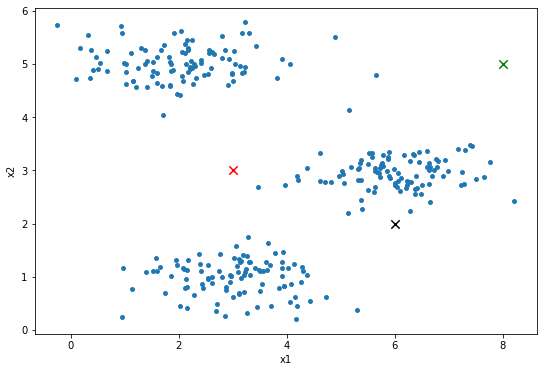

In [3]:
plt.figure(figsize=(9, 6))
plt.scatter(X1[:, 0], X1[:, 1], s=15)
corlor_lists = ['r', 'k', 'g']
for i in range(K):
    plt.scatter(init_centroids[i][0], init_centroids[i][1], s=70, marker='x', c=corlor_lists[i])
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

In [4]:
def findClosestCentroids(centroids, X):
    m = X.shape[0]
    k = centroids.shape[0]
    c = np.zeros(m)
    dis = np.zeros(k)

    for i in range(m):
        for j in range(k):
            dis[j] = np.sum(np.power(X[i] - centroids[j], 2))
        c[i] = np.argmin(dis) + 1

    return c

In [5]:
idx = findClosestCentroids(init_centroids, X1)
# idx == 2
idx[:3]

array([1., 3., 2.])

##### 1.1.2 Computing centroid means
Given assignments of every point to a centroid, the second phase of the algorithm recomputes, for each centroid, the mean of the points that were assigned to it. Specifically, for every centroid $k$ we set$$\mu_{k}:=\frac{1}{C_{k}}\sum\limits_{i\in C_{k}}x^{(i)}$$where $C_k$ is the set of examples that are assigned to centroid $k$. Concretely, if two examples say $x^{(3)}$ and $x^{(5)}$ are assigned to centroid $k=2$, then you should update $\mu_2=\frac{1}{2}(x^{(3)}+x^{(5)})$.

In [6]:
def computeCentroids(init_centroids, X, idx):
    k = init_centroids.shape[0]
    centroids = init_centroids

    for i in range(k):
        XCk = X[idx == i+1]
        centroids[i] = np.sum(XCk, axis=0) / XCk.shape[0]
    
    return centroids

In [7]:
computeCentroids(init_centroids, X1, idx)

array([[2.42830111, 3.15792418],
       [5.81350331, 2.63365645],
       [7.11938687, 3.6166844 ]])

#### 1.2 K-means on example data

In [8]:
def runKmeans(init_centroids, X):    
    k, n = init_centroids.shape
    path_centroids = {}
    for i in range(k):
        path_centroids[i+1] = np.array(init_centroids[i])

    centroids = init_centroids.copy()
    pre_centroids = np.zeros((centroids.shape))
    while True:
        idx = findClosestCentroids(centroids, X)
        centroids = computeCentroids(centroids, X, idx)
        if (centroids == pre_centroids).all():
            break
        else:
            for i in range(k):
                path_centroids[i+1] = np.vstack((path_centroids[i+1], centroids[i]))
            pre_centroids = centroids.copy()
    
    return idx, path_centroids

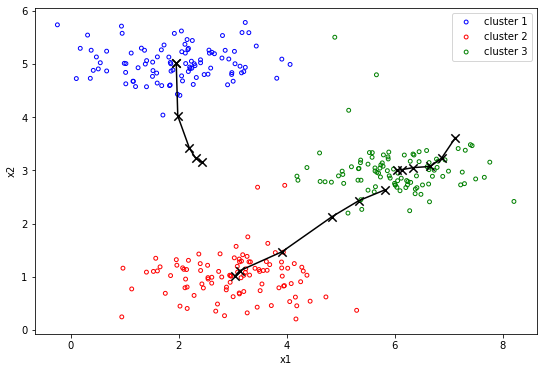

In [9]:
idx, path_centroids = runKmeans(init_centroids, X1)
plt.figure(figsize=(9, 6))
cluster1 = X1[idx == 1]
cluster2 = X1[idx == 2]
cluster3 = X1[idx == 3]
cluster1_path = path_centroids[1]
cluster2_path = path_centroids[2]
cluster3_path = path_centroids[3]
plt.scatter(cluster1[:, 0], cluster1[:, 1], s=15, c='none', marker='o', edgecolors='b', label='cluster 1')
plt.scatter(cluster1_path[:, 0], cluster1_path[:, 1], s=70, c='k', marker='x')
plt.plot(cluster1_path[:, 0], cluster1_path[:, 1], color='k')
plt.scatter(cluster2[:, 0], cluster2[:, 1], s=15, c='none', marker='o', edgecolors='r', label='cluster 2')
plt.scatter(cluster2_path[:, 0], cluster2_path[:, 1], s=70, c='k', marker='x')
plt.plot(cluster2_path[:, 0], cluster2_path[:, 1], color='k')
plt.scatter(cluster3[:, 0], cluster3[:, 1], s=15, c='none', marker='o', edgecolors='g', label='cluster 3')
plt.scatter(cluster3_path[:, 0], cluster3_path[:, 1], s=70, c='k', marker='x')
plt.plot(cluster3_path[:, 0], cluster3_path[:, 1], color='k')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()

In [10]:
def kMeansInitCentroids(X, K):
    m, n = X.shape
    init_centroids = np.empty((K, n))
    idx = np.random.randint(0, m, K)

    for i in range(K):
        init_centroids[i] = X[idx[i]]

    return init_centroids

#### 1.4 Image compression with K-means
By makeing this reduction, it is possible to represent (compress) the photo in an efficient way. Specifically, you only need to store the RGB values of the 16 selected colors, and for each pixel in the image you now need to only store the index of the color at that location (where only 4 bits are necessary to represent 16 possibilities).

In [11]:
image_data = io.loadmat('./data/bird_small.mat')
image_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'A'])

In [12]:
A = image_data['A']

# normalization
XImg = A / 255
# reshape
XImg = XImg.reshape(XImg.shape[0] * XImg.shape[1], -1)
XImg.shape

(16384, 3)

In [13]:
def runKmeansIter(init_centroids, X, iter):
    centroids = init_centroids.copy()

    for _ in range(iter):
        idx = findClosestCentroids(centroids, X)
        centroids = computeCentroids(centroids, X, idx)
    
    return idx, centroids

In [14]:
init_centroids = kMeansInitCentroids(XImg, 16)
idx, centroids = runKmeansIter(init_centroids, XImg, 50)

In [15]:
# get the last index
idx = findClosestCentroids(centroids, XImg)

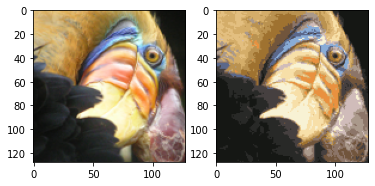

In [16]:
img = centroids[idx.astype(int)-1]      # nice method: map each pixel to the centroids value
img = img.reshape(A.shape[0], A.shape[1], A.shape[2])
plt.subplot(1, 2, 1)
plt.imshow(A)
plt.subplot(1, 2, 2)
plt.imshow(img)
plt.show()

### 2 Principal Component Analysis
In this exercise, you will use principal component analysis (PCA) to perform dimensionality reduction.

#### 2.1 Example data

In [24]:
data2 = io.loadmat('./data/ex7data1.mat')
data2.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X'])

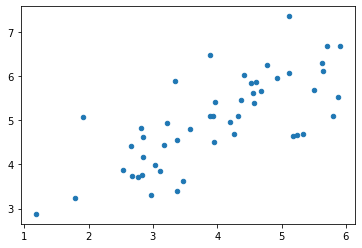

In [133]:
X2 = data2['X']
plt.scatter(X2[:, 0], X2[:, 1], s=20)
plt.show()

#### 2.2 Implementing PCA
PCA consists of two computational steps: First, you compute the covariance matrix of the data. Then, you use `SVD` function to compute the eigenvectors $U_1,U_2,...,U_n$. These will correspond to the principal components of variation in the data.

Before using PCA, it is important to first normalize the data by subtracting the mean value of each feature from the data, and scaling each dimension so that they are in the same range.$x_j=\frac{x_j-\mu_j}{\sigma_j^2}$

In [143]:
def featureNormalize(X):
    average = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    X = (X - average) / sigma
    return X, average, sigma

After normalizing the data, you can run PCA to compute the principal components. First you should compute the covariance matrix of the data, which is given by: $\Sigma=\frac{1}{m}X^TX$

In [131]:
def Sigma(X):
    return X.T @ X / X.shape[0]

In [137]:
def pca(X):
    X, _, _ = featureNormalize(X)
    cov = Sigma(X)

    return np.linalg.svd(cov)

In [144]:
U, S, V = pca(X2)
U, S, V

(array([[-0.70710678, -0.70710678],
        [-0.70710678,  0.70710678]]),
 array([1.73553038, 0.26446962]),
 array([[-0.70710678, -0.70710678],
        [-0.70710678,  0.70710678]]))

#### 2.3 Dimensionality Reduction with PCA
After computing the principal components, you can use them to reduce the feature dimension of your data by projecting each example onto a lower dimensional space, $x^{(i)}\to z^{(i)}$.

In [126]:
def projectData(X, U, k):
    U_reduce = U[:, :k]
    return X @ U_reduce

In [148]:
Z = projectData(X2, U, 1)

In [129]:
def recoverData(Z, U, k):
    U_reduce = U[:, :k]
    return Z @ U_reduce.T

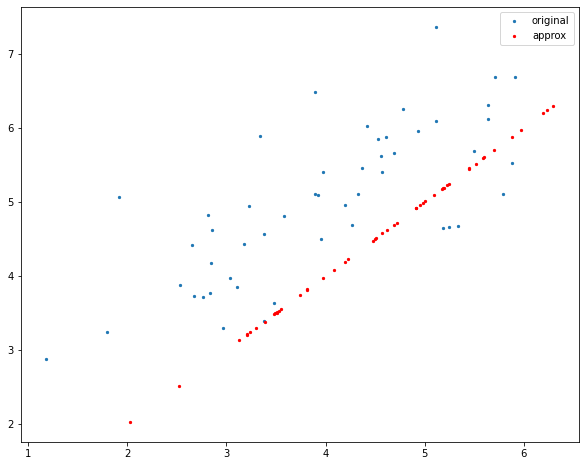

In [151]:
X2_rec = recoverData(Z, U, 1)
plt.figure(figsize=(10, 8))
plt.scatter(X2[:, 0], X2[:, 1], s=5, label='original')
plt.scatter(X2_rec[:, 0], X2_rec[:, 1], s=5, c='r', label='approx')
plt.legend()
plt.show()

#### 2.4 Face Image data

In [106]:
data_face = io.loadmat('./data/ex7faces.mat')
data_face.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X'])

In [110]:
def faceImg(X):
    return X.reshape((32, 32), order='F')

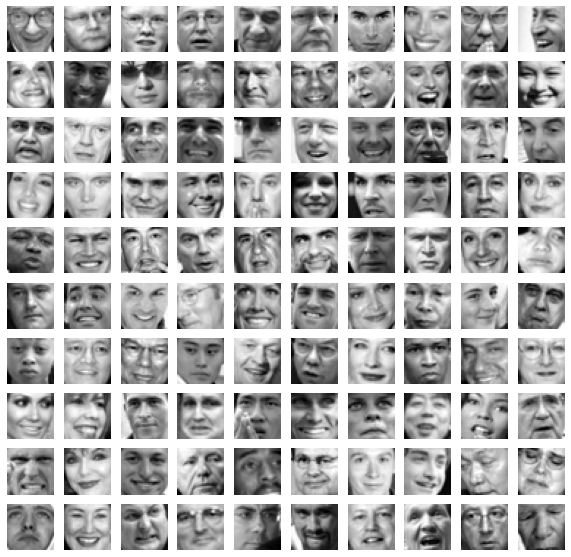

In [118]:
X_face = data_face['X']

plt.figure(figsize=(10, 10))
for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.imshow(faceImg(X_face[i]), cmap='gray')
    plt.axis('off')

In [173]:
U, S, V = pca(X_face)
U, S, V

(array([[-0.01425307, -0.03606596, -0.04561884, ...,  0.00521903,
          0.00091143,  0.00077515],
        [-0.01474233, -0.03809858, -0.04756249, ..., -0.01142763,
         -0.00228691, -0.00434598],
        [-0.01501482, -0.03988747, -0.05082085, ...,  0.01843345,
          0.00554132,  0.00873415],
        ...,
        [-0.00895052,  0.03119618, -0.05691806, ...,  0.0011493 ,
          0.00452914, -0.01218846],
        [-0.00769526,  0.0290752 , -0.05579144, ..., -0.00103011,
         -0.00647834,  0.00752741],
        [-0.00692969,  0.02725819, -0.05339471, ...,  0.00266801,
          0.00543461, -0.00218828]]),
 array([3.37025022e+02, 1.30938797e+02, 5.46935317e+01, ...,
        2.36058402e-04, 2.16424239e-04, 1.99417813e-04]),
 array([[-0.01425307, -0.01474233, -0.01501482, ..., -0.00895052,
         -0.00769526, -0.00692969],
        [-0.03606596, -0.03809858, -0.03988747, ...,  0.03119618,
          0.0290752 ,  0.02725819],
        [-0.04561884, -0.04756249, -0.05082085, ..

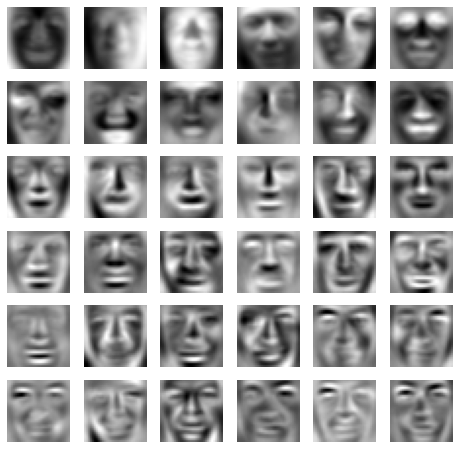

In [171]:
plt.figure(figsize=(8, 8))
for i in range(36):
    plt.subplot(6, 6, i+1)
    plt.imshow(faceImg(U[:, i]), cmap='gray')
    plt.axis('off')

In [175]:
Z = projectData(X_face, U, 100)
X_rec = recoverData(Z, U, 100)

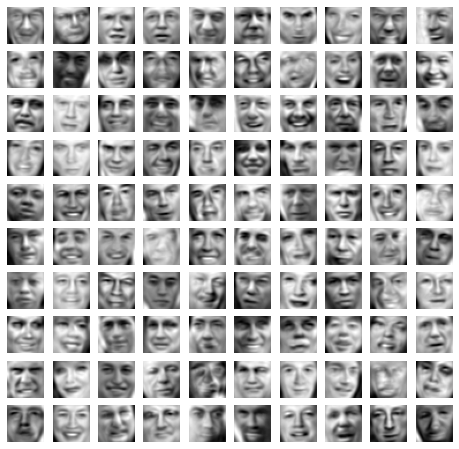

In [176]:
plt.figure(figsize=(8, 8))
for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.imshow(faceImg(X_rec[i]), cmap='gray')
    plt.axis('off')

#### 2.5 PCA for visualization

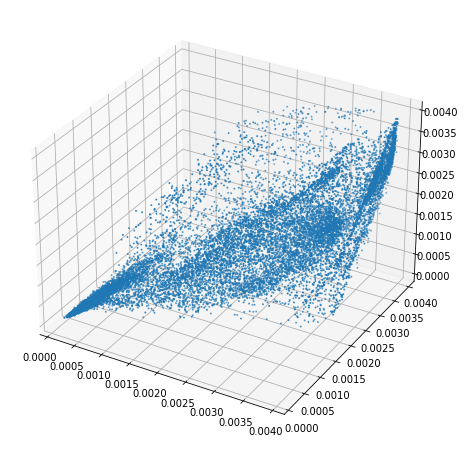

In [199]:
A = A / 255

plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.scatter3D(A[:, :, 0], A[:, :, 1], A[:, :, 2], s=1)
plt.show()

In [190]:
img

array([[[0.83191124, 0.67979094, 0.41403813],
        [0.89364602, 0.75169712, 0.50285205],
        [0.89364602, 0.75169712, 0.50285205],
        ...,
        [0.08383902, 0.09077237, 0.08052185],
        [0.08383902, 0.09077237, 0.08052185],
        [0.08383902, 0.09077237, 0.08052185]],

       [[0.89364602, 0.75169712, 0.50285205],
        [0.89364602, 0.75169712, 0.50285205],
        [0.89364602, 0.75169712, 0.50285205],
        ...,
        [0.08383902, 0.09077237, 0.08052185],
        [0.08383902, 0.09077237, 0.08052185],
        [0.08383902, 0.09077237, 0.08052185]],

       [[0.89364602, 0.75169712, 0.50285205],
        [0.89364602, 0.75169712, 0.50285205],
        [0.89364602, 0.75169712, 0.50285205],
        ...,
        [0.08383902, 0.09077237, 0.08052185],
        [0.08383902, 0.09077237, 0.08052185],
        [0.08383902, 0.09077237, 0.08052185]],

       ...,

       [[0.08383902, 0.09077237, 0.08052185],
        [0.08383902, 0.09077237, 0.08052185],
        [0.08383902, 0